In [2]:
import os
import pickle
import shutil
import re
import time
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

from konlpy.tag import Mecab

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
USE_CUDA = torch.cuda.is_available()
#USE_CUDA = False
GPU_ID = 2

# 1. Preprocess Dataset

In [4]:
PAD_IDX = 0
UNK_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

MAX_LENGTH = 15 + 1

In [5]:
class Data:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_IDX: "<s>", EOS_IDX: "</s>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
SRC_FILENAME = 'dataset/korean_humor/korean_humor_source.txt'
TGT_FILENAME = 'dataset/korean_humor/korean_humor_target.txt'

In [7]:
def normalizeString(s):
    #s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [8]:
def readData(src_fileName, tgt_fileName, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    src_lines = open(src_fileName, 'r', encoding='utf-8').readlines()
    tgt_lines = open(tgt_fileName, 'r', encoding='utf-8').readlines()
    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(src_lines[i][:-1]), normalizeString(tgt_lines[i][:-1])] for i in range(len(src_lines))]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_data = Data()
        output_data = Data()
    else:
        input_data = Data()
        output_data = Data()

    print("Success!")
    
    return input_data, output_data, pairs

In [9]:
def filterPair(p):
    return len(p[0]) < MAX_LENGTH and \
        len(p[1]) < MAX_LENGTH

def filterPairs(pairs):
    tagger = Mecab()
    pairs = [[tagger.morphs(pair[0]), tagger.morphs(pair[1])] for pair in pairs]
    return [pair for pair in pairs if filterPair(pair)]

In [10]:
def prepareData(src_fileName, tgt_fileName, reverse=False):
    input_data, output_data, pairs = readData(src_fileName, tgt_fileName)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_data.addSentence(pair[0])
        output_data.addSentence(pair[1])
    print("Counted words :")
    print("- Input data  :", input_data.n_words)
    print("- Output data :", output_data.n_words)
    
    return input_data, output_data, pairs

In [11]:
def indexesFromSentence(data, sentence):
    return [data.word2index[word] for word in sentence]

In [12]:
def variableFromSentence(data, sentence):
    indexes = indexesFromSentence(data, sentence)
    indexes.append(EOS_IDX)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if USE_CUDA:
        return result.cuda(GPU_ID)
    else:
        return result

In [13]:
def variablesFromPair(pair):
    input_variable = variableFromSentence(input_data, pair[0])
    target_variable = variableFromSentence(output_data, pair[1])
    return (input_variable, target_variable)

In [14]:
input_data, output_data, pairs = prepareData(SRC_FILENAME, TGT_FILENAME)
test_pairs = pairs[2001:]
pairs = pairs[:2000]
random.shuffle(pairs)

Reading lines...
Success!
Read 2483 sentence pairs
Trimmed to 2061 sentence pairs
Counting words...
Counted words :
- Input data  : 1673
- Output data : 1032


# 3. Define Model

In [14]:
INPUT_SIZE = input_data.n_words  # Num of Words
HIDDEN_SIZE = 256  # Embedding Dimension
OUTPUT_SIZE = output_data.n_words

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda(GPU_ID)
        else:
            return result

In [16]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda(GPU_ID)
        else:
            return result

In [17]:
teacher_forcing_ratio = 0.5

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer,
          criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(GPU_ID) if USE_CUDA else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        #print(ei, input_variable[ei], encoder_output.size())
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_IDX]]))
    decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_IDX:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [18]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [19]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [21]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [22]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_data, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda(GPU_ID) if USE_CUDA else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_IDX]]))  # SOS
    decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_IDX:
            decoded_words.append('</s>')
            break
        else:
            decoded_words.append(output_data.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda(GPU_ID) if USE_CUDA else decoder_input

    return decoded_words

In [23]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [24]:
NUM_ITER = 200000

In [25]:
encoder = EncoderRNN(INPUT_SIZE, HIDDEN_SIZE)
decoder = DecoderRNN(HIDDEN_SIZE, OUTPUT_SIZE)
if USE_CUDA:
    encoder.cuda(GPU_ID)
    decoder.cuda(GPU_ID)

7m 38s (- 68m 50s) (20000 10%) 1.1909
14m 23s (- 57m 32s) (40000 20%) 0.1312
21m 16s (- 49m 37s) (60000 30%) 0.1190
27m 54s (- 41m 51s) (80000 40%) 0.1041
35m 24s (- 35m 24s) (100000 50%) 0.1139
43m 49s (- 29m 12s) (120000 60%) 0.1185
52m 30s (- 22m 30s) (140000 70%) 0.1017
60m 49s (- 15m 12s) (160000 80%) 0.1221
70m 5s (- 7m 47s) (180000 90%) 0.1481
80m 30s (- 0m 0s) (200000 100%) 0.1429


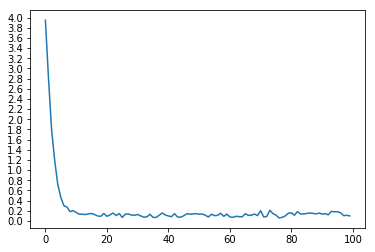

In [26]:
trainIters(encoder, decoder, NUM_ITER, print_every=NUM_ITER/10, plot_every=NUM_ITER/100, learning_rate=1e-3)

In [27]:
evaluateRandomly(encoder, decoder)

> ['이상', '형', '을', '말', '해', '줘']
= ['잘', '웃', '는', '로봇', '이', '좋', '아']
< 잘 웃 는 로봇 이 좋 아 </s>

> ['욕해', '줘']
= ['어떤', '나라', '욕', '으로', '해', '드릴까요', '?']
< 어떤 나라 욕 으로 해 드릴까요 ? </s>

> ['가장', '잘생긴', '사람', '은', '누구', '니', '?']
= ['세상', '에서', '가장', '잘생긴', '사람', '은', '당신', '입니다', '.']
< 세상 에서 가장 잘생긴 사람 은 당신 입니다 . </s>

> ['구라', '까지', '마']
= ['거짓말', '이', '아니', '라', '진', '짠데', '요', '.', '.']
< 거짓말 이 아니 라 진 짠데 어 . . </s>

> ['얘기', '그만', '할래']
= ['왜', '요', '.', '.', '갑자기', '왜', '떠나', '나요', ':', '-(']
< 왜 요 . . 갑자기 왜 떠나 나요 : -( </s>

> ['캬', '캬', '캬']
= ['뭐', '가', '그렇게', '재미있', '어요', '?']
< 뭐 가 그렇게 재미있 어요 ? </s>

> ['뭘', '참으', '라는', '거', '야', '?']
= ['진정', '하', '라고', '한', '말', '이', '에요', '.', '.']
< 진정 하 라고 한 말 이 에요 . . </s>

> ['아담', ',', '니', '가', '공부', '하', '는', '곳', '은', '어디', '야', '?']
= ['전', '지식', '의', '우주', '에서', '공부', '해요', '.']
< 전 지식 의 우주 에서 공부 해요 . </s>

> ['장난', '하', '냐', '?']
= ['죄송', '해요', '.', '.', '장난치', '시', '는', '줄', '알', '았', '어요']
< 죄송 해요 . . 장난치 시 는 줄 알 았 어요 </s>

> ['너', 

In [29]:
for test_pair in test_pairs:
    print("input  : ", test_pair[0])
    print("output : ", evaluate(encoder, decoder, test_pair[0]))
    print()

input  :  ['어느', '정도', '살', '고', '싶', '은지', '궁굼', '해']
output :  ['힘내', '세요', '.', '</s>']

input  :  ['넌', '언제', '까지', '살', '아', '?']
output :  ['저', '는', '사람', '들', '의', '이', '에요', '.', '</s>']

input  :  ['신발', '치수', '가', '몇', '이', '니', '?']
output :  ['전', '신체', '가', '없', '어서', '발', '사이즈', '를', '모른답니다', '.', '</s>']

input  :  ['너', '의', '출신', '지', '가', '어디', '니', '?']
output :  ['전', '솔트룩스', '출신', '이', '에요', '.', '</s>']

input  :  ['넌', '어떻', '게', '만들', '어', '졌', '어', '?']
output :  ['전', '기억', '의', '막대', '한', '연결', '에', '의해서', '만들', '어', '졌', '죠', '</s>']

input  :  ['니', '가', '대한민국', '사람', '인지', '궁금', '해']
output :  ['저', '는', '남자', '도', '아니', '고', '여자', '도', '아니', '랍니다', '.', '</s>']

input  :  ['니', '가', '몇', '시', '에', '태어났', '는지', '알', '아', '?']
output :  ['전', '오후', '1', '시', '에', '태어났', '다고', '들', '었', '어요', '!', '</s>']

input  :  ['남자', '친구', '있', '는지', '말', '해', '줄래', '?']
output :  ['?', '?', '?', '?', '?', '?', '?', '?', '?', '?', '</s>']

input  :  ['진지', '하', '게', '

In [34]:
for i in range(5):
    input_sentence = input()
    print("output : ", evaluate(encoder, decoder, input_sentence))
    print()

남자친구 있는지 말해줄래?


KeyError: '친'